# 深圳签订外贸合同量预测ARIMA模型

## 使用到的模块及其安装

 - Python version: 3.11.0
 - Pandas version: 2.2.3
    - pip install pandas==2.2.3
 - Matplotlib version: 3.10.1
    - pip install matplotlib==3.10.1
 - Statsmodels version:
    - pip install statsmodels==0.14.4

In [315]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas.tseries.offsets import DateOffset
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import matplotlib as mpl
mpl.rcParams['font.family'] = 'SimHei'
mpl.rcParams['axes.unicode_minus'] = False
import matplotlib.pyplot as plt
%matplotlib inline

In [316]:
df=pd.read_excel('深圳签订外贸合同项数数据1990~2023.xlsx')

# 获取全部的列名列表
# all_columns = df.columns.tolist()
# print(all_columns)

# 输入一个需要预测的国家或地区
"""
    '中国香港、澳门', '中国台湾', '新加坡', '韩国', '日本', 
    '泰国', '澳大利亚', '马来西亚', '美国', '加拿大', 
    '德国', '法国', '英国', '瑞士', '荷兰', '其他'
"""
need_to_predict = str(input("请输入您需要预测的国家："))
# print(need_to_predict)

# 保留单一列数据，用于预测。这里以用户指定的国家/地区为例（'中国香港、澳门'）。
df_total = df[['时间', need_to_predict]].copy()

print('原数据预览：\n', df.head())
print('保留后数据预览：\n', df_total.head())

原数据预览：
      时间  中国香港、澳门  中国台湾  新加坡  韩国  日本  泰国  澳大利亚  马来西亚   美国  加拿大  德国  法国  英国  瑞士  \
0  1990      699    45    5   0  12   2     2     1   16    2   0   1   2   3   
1  1991      885    36    8   3  17   3     1     0   18    2   2   3   2   1   
2  1992     1330    88   20   5  16   8     6     3   57    8   1   2   5   0   
3  1993     2834   154   24   8  27  15    14     5  104   22   2   4  16   2   
4  1994     1885   124   29   8  25   8     7     3   74   10   5   3  19   0   

   荷兰  其他  
0   0   6  
1   1   4  
2   1  11  
3   3  23  
4   1  22  
保留后数据预览：
      时间  其他
0  1990   6
1  1991   4
2  1992  11
3  1993  23
4  1994  22


## 进出口总额预测处理

In [317]:
# 修改列标题
df_total.columns = ["日期", need_to_predict]
# 转化时间数据为 datetime 对象
df_total['日期'] = pd.to_datetime(df_total['日期'], format='%Y')

# 设置时间索引
df_total.set_index('日期', inplace=True)
df_total.head()

,其他
日期,
1990-01-01,6
1991-01-01,4
1992-01-01,11
1993-01-01,23
1994-01-01,22


In [318]:
# 获取数据描述
df_total.describe()

,其他
count,34.000000
mean,256.911765
std,292.509660
min,4.000000
25%,63.250000
50%,189.500000
75%,326.500000
max,1363.000000


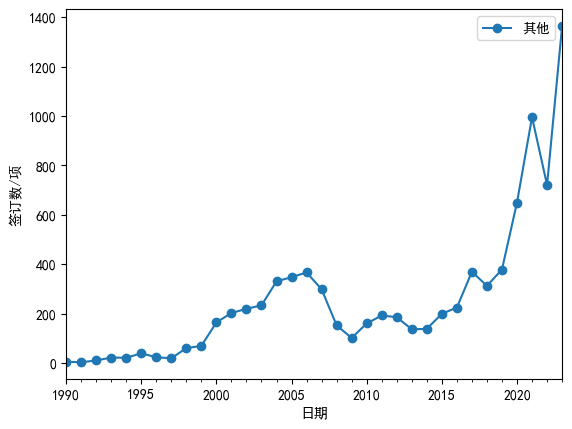

In [319]:
# 原始数据可视化绘图
df_total.plot(kind='line', marker='o')
plt.ylabel('签订数/项')
plt.show()

In [320]:
# ADF 检验函数
# H0：它是非平稳的  
# H1：它是平稳的
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF检验统计量', 'p值', '使用的滞后数', '使用的观测值数量']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("反对原假设(H0)的有力证据，否定原假设。数据没有单位根，并且是平稳的。")
    else:
        print("反对零假设的弱证据，时间串行有一个单位根，表明它是非平稳的。")

In [321]:
# ADF 检验1：原始数据平稳
adfuller_test(df_total[need_to_predict])

ADF检验统计量 : 0.5746966767212214
p值 : 0.9869750529775104
使用的滞后数 : 8
使用的观测值数量 : 25
反对零假设的弱证据，时间串行有一个单位根，表明它是非平稳的。


In [322]:
# 差分操作
df_total['一阶差分'] = df_total[need_to_predict] - df_total[need_to_predict].shift(1)   # 一阶差分
df_total.head(14)

,其他,一阶差分
日期,,
1990-01-01,6,NaN
1991-01-01,4,-2.0
1992-01-01,11,7.0
1993-01-01,23,12.0
1994-01-01,22,-1.0
1995-01-01,40,18.0
1996-01-01,24,-16.0
1997-01-01,20,-4.0
1998-01-01,61,41.0


In [323]:
# ADF 检验2：经过差分处理后比未处理前效果更好
print("一阶差分：")
adfuller_test(df_total['一阶差分'].dropna())

一阶差分：
ADF检验统计量 : -0.4338502281685321
p值 : 0.9042917467503464
使用的滞后数 : 6
使用的观测值数量 : 26
反对零假设的弱证据，时间串行有一个单位根，表明它是非平稳的。


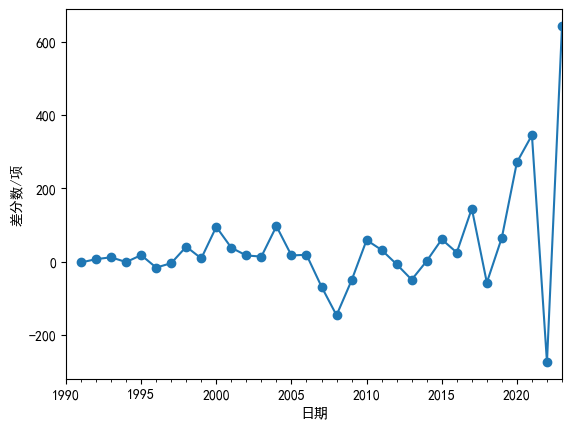

In [324]:
# 绘制可视化图像
df_total['一阶差分'].plot(kind='line', marker='o')
plt.ylabel('差分数/项')
plt.show()

### 自动回归模型


自回归模型（AR模型）的一般形式：

$$ y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \cdots + \phi_p y_{t-p} + \varepsilon_t $$

其中：
- $ y_t $ 是时间序列在时间 t 的值。
- $ c $ 是常数项。
- $ \phi_1, \phi_2, \ldots, \phi_p $ 是模型参数，分别代表不同滞后项的系数。
- $ y_{t-1}, y_{t-2}, \ldots, y_{t-p} $ 是时间序列在 t-1, t-2, ..., t-p 时刻的值，即滞后项。
- $ \varepsilon_t $ 是误差项，通常假设为白噪声序列。
- $ p $ 是模型的阶数，表示考虑的滞后项的数量。

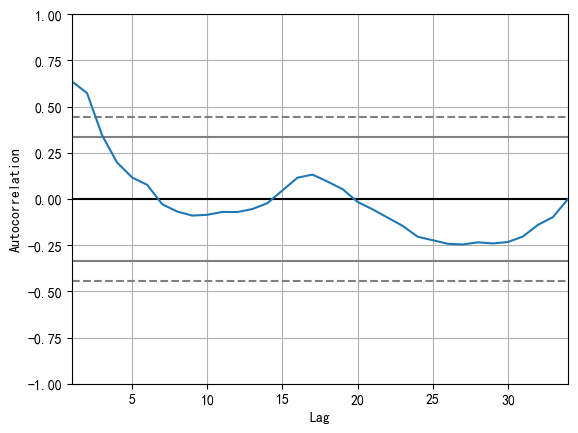

In [325]:
# 绘制自相关图
autocorrelation_plot(df_total[need_to_predict])
plt.show()

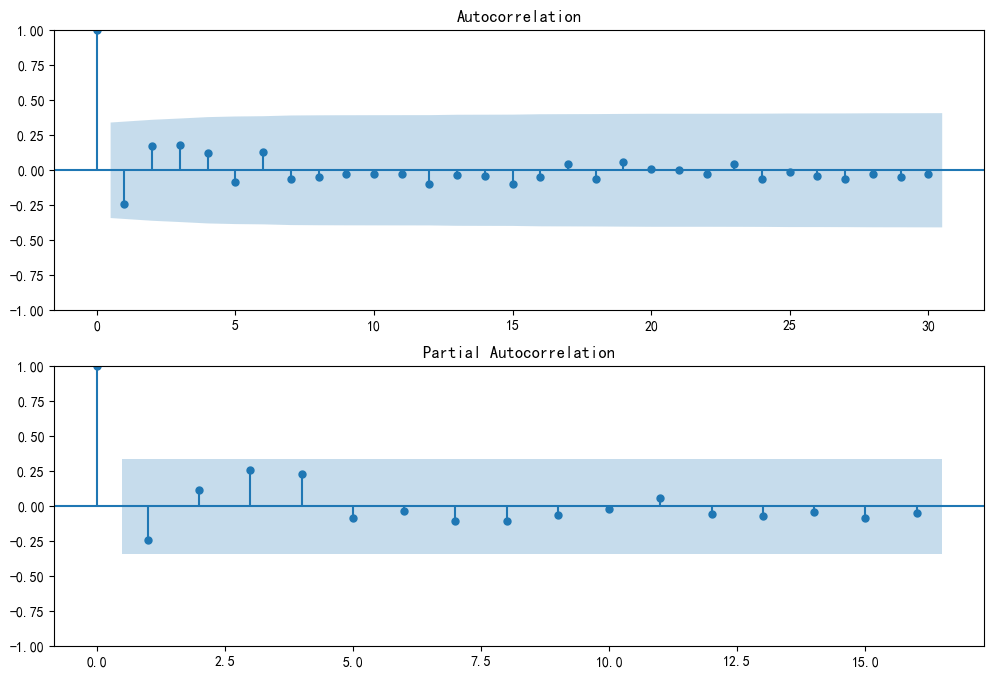

In [326]:
fig1 = plt.figure(figsize=(12,8))
ax1 = fig1.add_subplot(211)
fig1 = plot_acf(df_total['一阶差分'].iloc[1:], lags=30, ax=ax1)   # 绘制自相关函数（ACF）图
ax2 = fig1.add_subplot(212)
fig1 = plot_pacf(df_total['一阶差分'].iloc[1:], lags=16, ax=ax2)  # 偏自相关函数（PACF）图

### 拟合

e:\Python\miniconda\envs\ip311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
e:\Python\miniconda\envs\ip311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
e:\Python\miniconda\envs\ip311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


<Axes: xlabel='日期'>

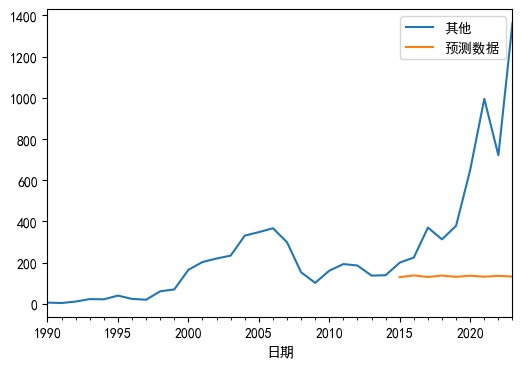

In [327]:
# 一阶差分ARIMA模型
# 使用ARIMA模型对数据进行建模，其中包含一阶差分以使数据平稳
model_one = ARIMA(df_total[need_to_predict], order=(1, 1, 1))
one_fit = model_one.fit()

# 使用拟合后的模型进行预测
df_total['预测数据'] = one_fit.predict(start=25, end=35, dynamic=True)
df_total[[need_to_predict, '预测数据']].plot(figsize=(6, 4))

In [328]:
future_dates=[df_total.index[-1]+ DateOffset(years=x)for x in range(1, 11)]
future_datest_df=pd.DataFrame(index=future_dates[0:],columns=df_total.columns)

In [329]:
# 一阶差分ARIMA模型的拟合效果更佳
future_df=pd.concat([df_total,future_datest_df])
future_df['预测数据'] = one_fit.predict(start = 34, end = 46, dynamic= True)
future_df.tail()

C:\Users\31561\AppData\Local\Temp\ipykernel_17160\3900604843.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  future_df=pd.concat([df_total,future_datest_df])


,其他,一阶差分,预测数据
2029-01-01,NaN,NaN,1277.600252
2030-01-01,NaN,NaN,1115.635483
2031-01-01,NaN,NaN,1259.964188
2032-01-01,NaN,NaN,1131.351187
2033-01-01,NaN,NaN,1245.959740


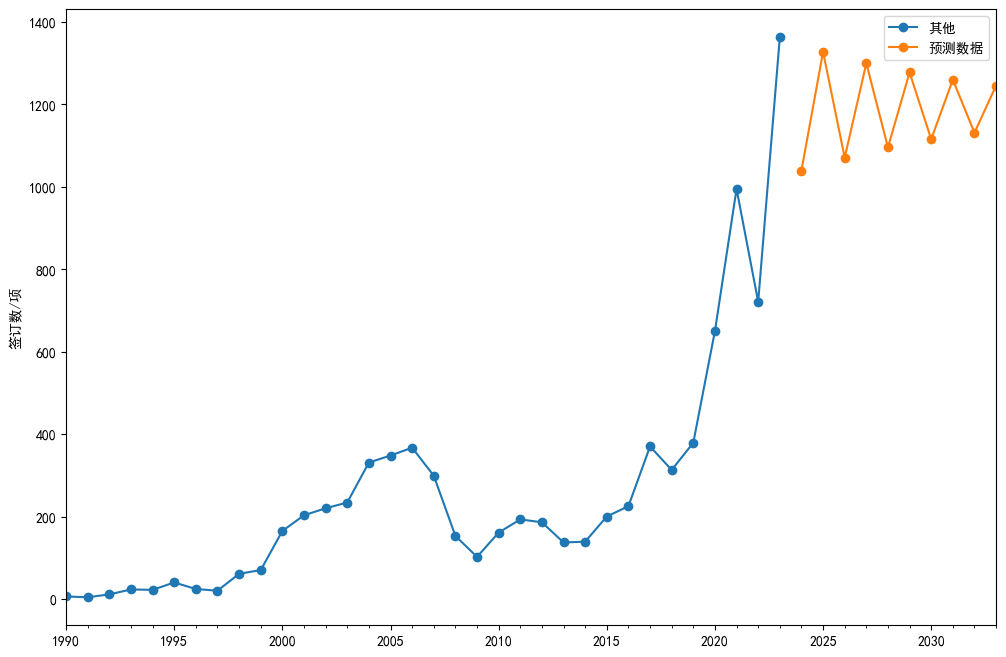

In [330]:
future_df[[need_to_predict, '预测数据']].plot(figsize=(12, 8), kind='line', marker='o') 
plt.ylabel('签订数/项')
plt.show()

In [331]:
# 保存时间和预测数据列到Excel文件
future_df.to_excel(f'end_out({need_to_predict}).xlsx')